## Cloud Storage

https://drive.google.com/drive/folders/1leUWa8GR02X2sVX12q4tYPgFTQ6YhQZq?usp=sharing

Files with numeric file names are data from human subjects. You should decompress these files into preproc_data directory which is in WinterCamp2021.zip .

## Main

In [1]:
from datetime import date
from glob import glob
import os, sys
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

import nilearn.image, nilearn.masking
from nilearn import plotting as nplt
import nilearn.decoding

import statsmodels.stats.multitest

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.svm import LinearSVC

In [2]:
%matplotlib inline
today = date.today().strftime("%Y%m%d")

In [3]:
id_list = ['GA', 'GB']
nn_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
           '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
           '31', '32', '33', '34', '35', '36']
run_list = ['r01', 'r02', 'r03', 'r04', 'r05', 'r06']

In [4]:
root_dir = '/Users/clmnlab/Desktop/WinterCamp2021' # check where the data is downloaded on your disk

In [5]:
preproc_dir = root_dir + '/preproc_data'
mask_dir = root_dir + '/masks'
loc_dir = mask_dir + '/localizer'

In [6]:
def fast_masking(img, roi):
    # img : data (NIFTI image)
    # roi : mask (NIFTI image)
    # output : (times, voxels)-dimensional fdata array
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    return img_data[roi_mask, :].T    # the shape is (times, voxels) which is to cross-validate for times(=runs)

In [7]:
## LDA analysis
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [8]:
def cross_valid(estimator, ROI_imgs, pickle_name):
    # estimator : model
    # ROI_imgs : nifti image
    # pickle_name : string
    # output : A leave-one-run-out cross-validation (LORO-CV) result. 
    #          Automatically save it as pickle file to root_dir
    ## set the parameters
    nrun = 3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number
    
    ## cross-validation
    pkl = {}
    for ii in id_list:
        for nn in nn_list:
            subj = ii + nn
            for roi, roi_img in ROI_imgs.items():
                print(subj, roi, end='\r')
                for i, pp in enumerate(['practiced','unpracticed']):
                    temp = nilearn.image.concat_imgs([data[subj,rr] for rr in run_list[i*3:(i+1)*3]])
                    X = fast_masking(img=temp, roi=roi_img)
                    score = cross_validate(estimator=estimator, X=X, y=y, groups=group
                                           , cv=cv, return_estimator=True, return_train_score=True)
                    pkl[subj, roi, pp] = np.mean(score['test_score'])
                
    ## Save as .pickle
    with open(join(root_dir,today+'_%s.pkl'%pickle_name),"wb") as fw:
        pickle.dump(pkl, fw)
        
    return pkl

In [9]:
# def show_pkl_list(word):
#     pkl_list = glob(join(root_dir,'*%s*.pkl'%word))
#     df = pd.DataFrame({'name':pkl_list})
#     group = ['' for i in pkl_list]

#     ## check the identity
#     idty = ['a','b','c','d','e','f','g','h','i','j','k','l','m'
#             ,'n','o','p','q','r','s','t','u','v','w','x','y','z'
#             ,'A','B','C','D','E','F','G','H','I','J','K','L','M'
#             ,'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
#     gg = 0
#     for n,p in enumerate(pkl_list):
#         ## assign a pkl a name of the group
#         ## check whether the pkl has a group or not
#         if len(group[n])!=0:
#             continue
#         group[n] = idty[gg]
#         ## check the similarity
#         with open(p,"rb") as fp:
#             pkl_n = pickle.load(file=fp)
#         for m,q in enumerate(pkl_list[(n+1):]):
#             if len(group[m+n+1])!=0:
#                 continue
#             if getsize(join(root_dir,p))!=getsize(join(root_dir,q)):
#                 continue
#             ## Comparison sorting
#             with open(q,"rb") as fq:
#                 pkl_m = pickle.load(file=fq)
#             all_same = True
#             for key in pkl_n.keys():
#                 if not np.array_equal(pkl_n[key], pkl_m[key]):
#                     all_same = False
#                     break
#             if all_same:
#                 group[m+n+1] = idty[gg]
#         gg += 1
#     df['identity']=group
    
#     return df

In [10]:
def make_dataframe(roi_list, pkl):
    wit_df = pd.DataFrame(columns=['subj', 'roi_name', 'Mapping', 'Mean Accuracy', 'Stage'])

    for ii in id_list:
        ss = 'Early' if ii == 'GA' else 'Late'
        for nn in nn_list:
            subj = ii + nn
            for roi_name in roi_list:
                for pp in ['unpracticed', 'practiced']:
                    wit_df = wit_df.append(
                        {'subj': subj
                         ,'roi_name': roi_name
                         ,'Mapping': pp
                         ,'Mean Accuracy': np.mean(pkl[subj, roi_name, pp])
                         ,'Stage': ss}
                        , ignore_index=True)
    return wit_df

In [11]:
def wit_df_t_test(wit_df, roi_list, compare, criteria):
    gg = wit_df[compare].unique()
    key = list(criteria.keys())[0]
    value = list(criteria.values())[0]
    
    ttest = {}
    res = {}

    for roi in roi_list:
        sub_df = wit_df[(wit_df['roi_name'] == roi) & (wit_df[key] == value)]

        mean_accs = [sub_df[sub_df[compare] == i]['Mean Accuracy'] for i in gg]

        ttest[roi] = scipy.stats.ttest_rel(mean_accs[0], mean_accs[1])
        res[roi] = statsmodels.stats.multitest.fdrcorrection(ttest[roi].pvalue)

    return res

# MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

In [12]:
## background image
img_bg = join(root_dir,'mni152_2009bet.nii.gz')

## Loading $\beta$s

In [13]:
## load betas
data = {}

for ii in id_list:
    for nn in nn_list:
        subj = ii + nn
        print(subj, end='\r')
        for run in run_list:
            data[subj, run] = nilearn.image.load_img(join(preproc_dir,nn,'betasLSS.%s.%s.nii.gz'%(subj,run)))

## We suppose to exclude the first slice from the last dimension of this 4D-image
print('indexing...', end='\r')
for key, value in data.items():
    data[key] = nilearn.image.index_img(value, np.arange(1, 97))

In [14]:
## labeling with target position
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

with open(join(root_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
target_path = list(range(1,13))*8

## Movement-related ROIs from localizer

In [16]:
roi_imgs = {}
## ROIs
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    roi_imgs[roi] = nilearn.image.load_img(path)

In [17]:
roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fedd98d5a00>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fedd98e9b20>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fe939793b50>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fedd98e9790>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7ffad7793ac0>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fedd98dd0d0>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fedd98dd1c0>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7fedd98c55e0>}

### calculate and store the result as a pickle file

In [18]:
results = cross_valid(estimator=estimator, ROI_imgs=roi_imgs, pickle_name='dec-acc_move-rel')

### read the above pickle

In [19]:
pkls = glob(join(root_dir,'*dec-acc_move-rel.pkl'))
pkls

['/Users/clmnlab/Desktop/WinterCamp2021/20210218_dec-acc_move-rel.pkl']

In [20]:
## Load pickle
with open(pkls[0],"rb") as fr:
    results = pickle.load(file=fr)
roi_names = sorted(set([rr for _, rr, _ in results.keys()]))
# print(results)

### Data table

In [21]:
wit_df = make_dataframe(roi_list=roi_names, pkl=results)
wit_df

,subj,roi_name,Mapping,Mean Accuracy,Stage
0,GA01,n200_c1-1_L_M1,unpracticed,0.315972,Early
1,GA01,n200_c1-1_L_M1,practiced,0.368056,Early
2,GA01,n200_c1-2_L_S1,unpracticed,0.420139,Early
3,GA01,n200_c1-2_L_S1,practiced,0.357639,Early
4,GA01,n200_c2_R_CerebellumIV-V,unpracticed,0.315972,Early
...,...,...,...,...,...
827,GB36,n200_c5_R_SMA,practiced,0.291667,Late
828,GB36,n200_c6_R_CerebellumVIIIb,unpracticed,0.315972,Late
829,GB36,n200_c6_R_CerebellumVIIIb,practiced,0.274306,Late
830,GB36,n200_c7_L_Thalamus,unpracticed,0.267361,Late


### t-test

In [22]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, compare='Stage', criteria={'Mapping':'practiced'})

{'n200_c1-1_L_M1': (array([ True]), array([0.00111244])),
 'n200_c1-2_L_S1': (array([ True]), array([0.00073907])),
 'n200_c2_R_CerebellumIV-V': (array([ True]), array([0.04699614])),
 'n200_c3_R_Postcentral': (array([False]), array([0.06451947])),
 'n200_c4_L_Putamen': (array([False]), array([0.38458666])),
 'n200_c5_R_SMA': (array([False]), array([0.33140306])),
 'n200_c6_R_CerebellumVIIIb': (array([False]), array([0.98995396])),
 'n200_c7_L_Thalamus': (array([False]), array([0.29241165]))}

In [23]:
wit_df_t_test(wit_df=wit_df, roi_list=roi_names, compare='Mapping', criteria={'Stage':'Late'})

{'n200_c1-1_L_M1': (array([ True]), array([0.03128686])),
 'n200_c1-2_L_S1': (array([ True]), array([0.01883729])),
 'n200_c2_R_CerebellumIV-V': (array([False]), array([0.50468989])),
 'n200_c3_R_Postcentral': (array([False]), array([0.62604011])),
 'n200_c4_L_Putamen': (array([False]), array([0.67569115])),
 'n200_c5_R_SMA': (array([False]), array([0.69423328])),
 'n200_c6_R_CerebellumVIIIb': (array([False]), array([0.68788733])),
 'n200_c7_L_Thalamus': (array([False]), array([0.2595322]))}

### Drawing figures

In [24]:
sns.set(style="ticks", context='talk')
palette = ['#C5C7D2', '#00A8AA', '#C5C7D2', '#00A8AA']

def draw_lineplot(roi_name, title, ax=None):
    
    sub_df = wit_df[wit_df['roi_name'] == roi_name]
    ax = sns.pointplot(x='Stage', y='Mean Accuracy', hue='Mapping', data=sub_df, ax=ax,
                  palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.70,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

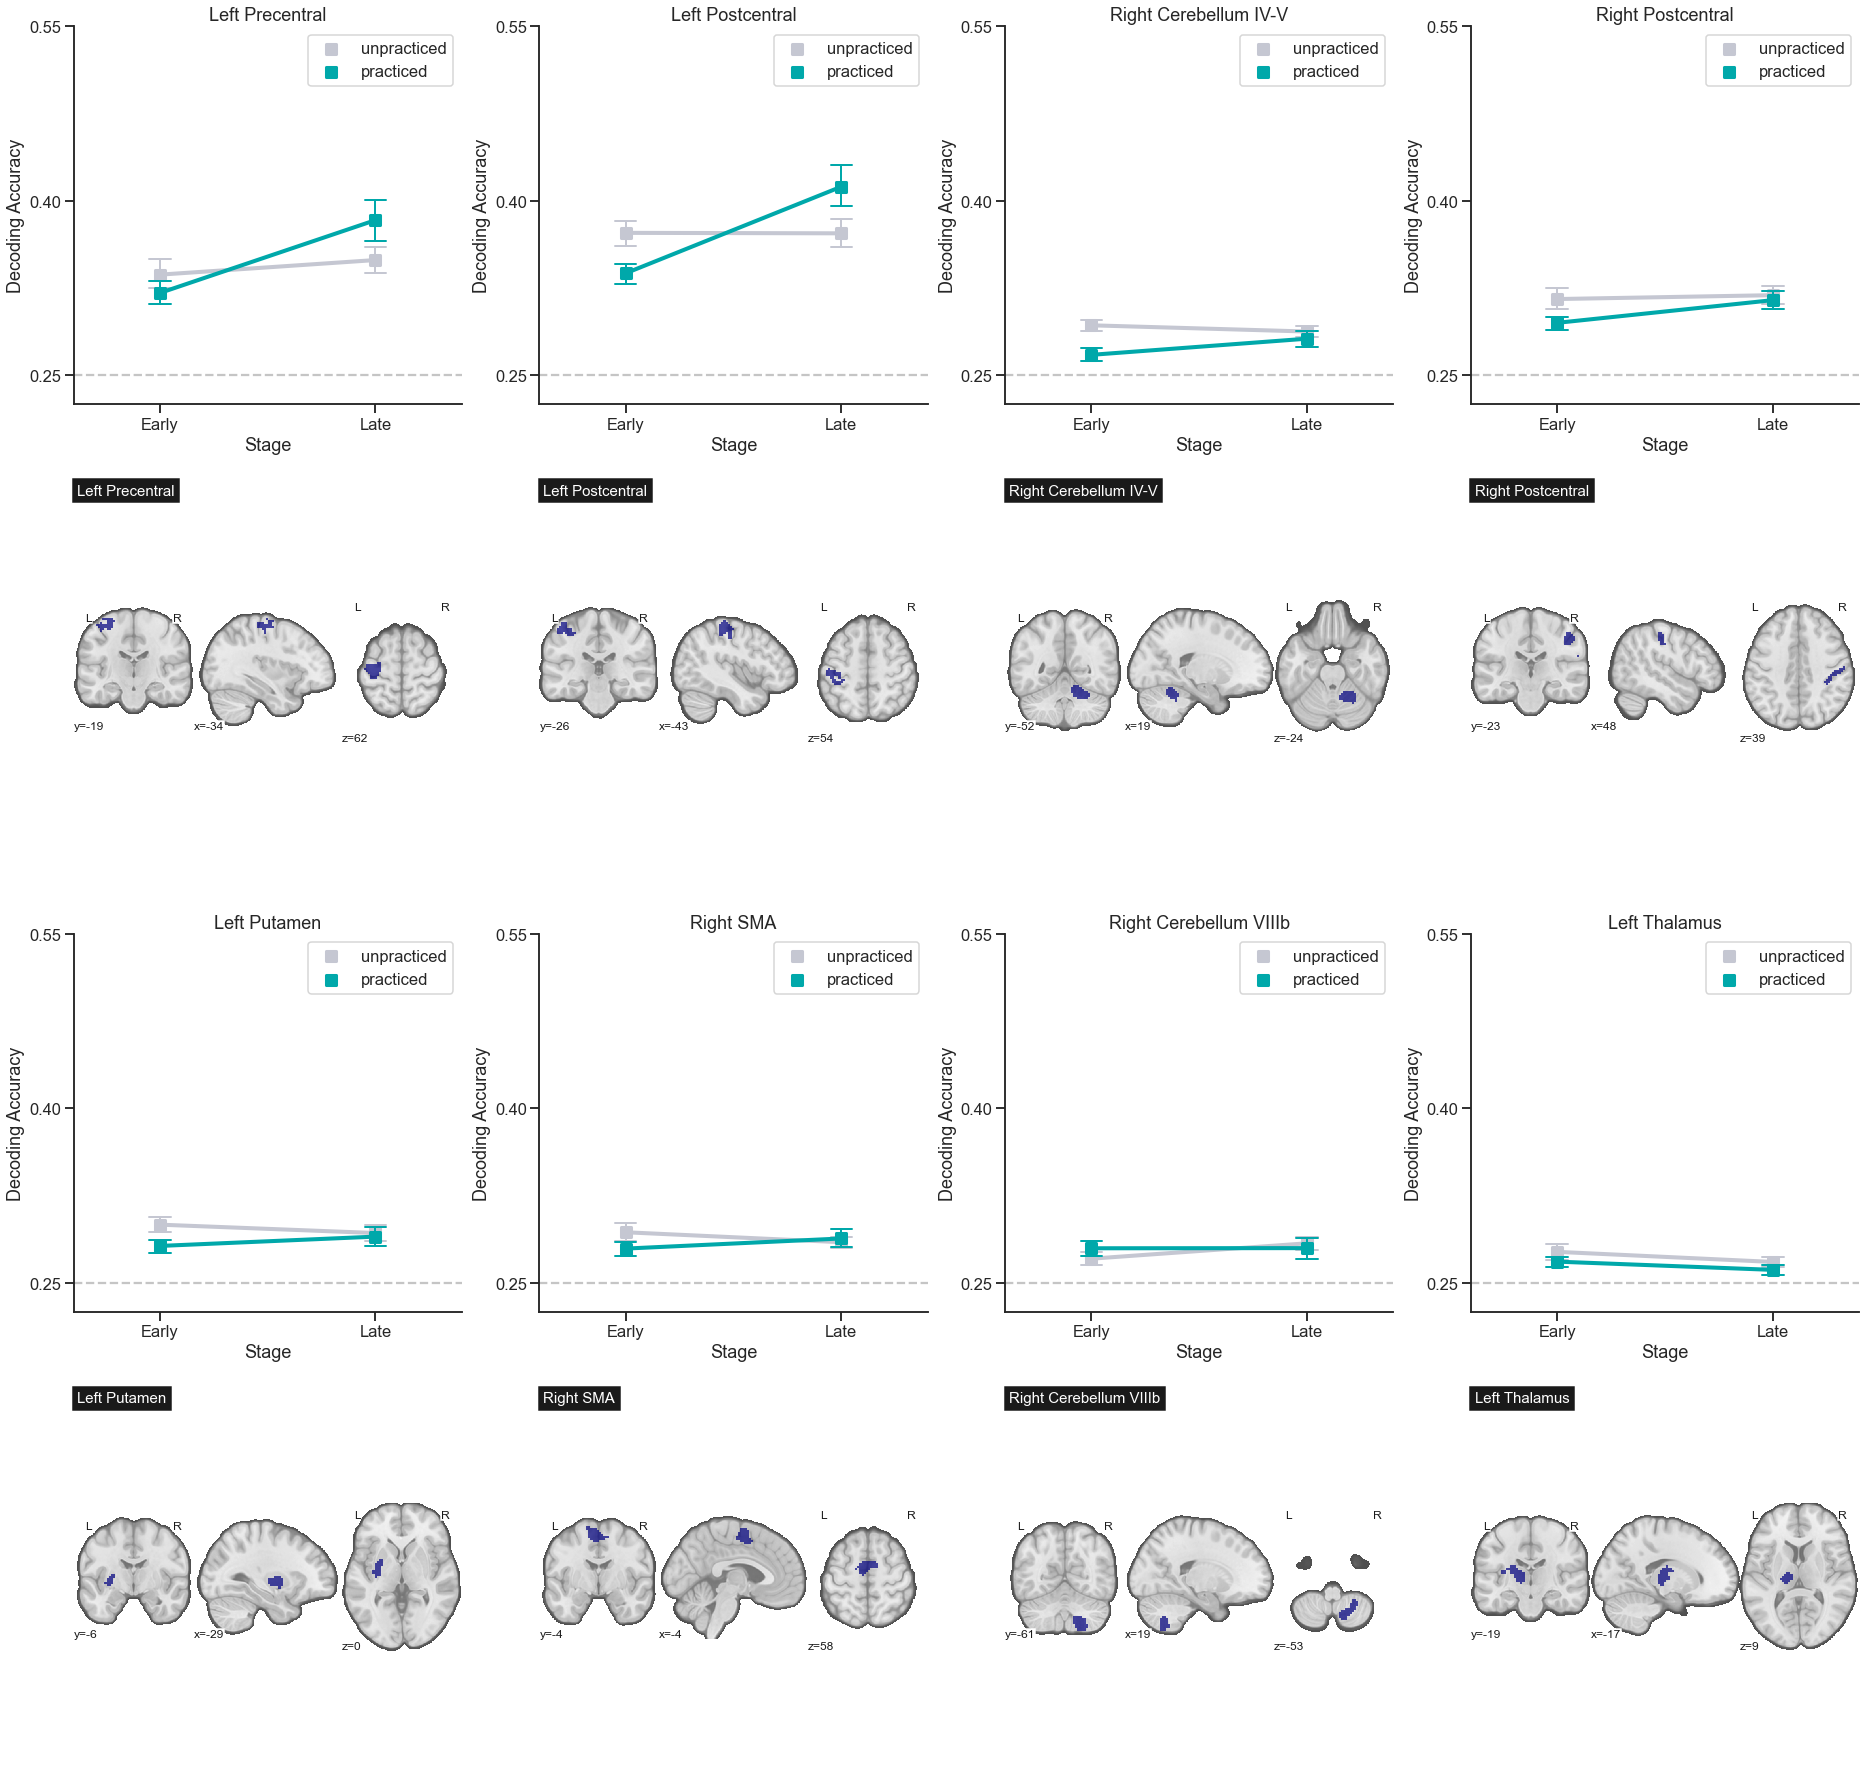

In [25]:
name_list = ['Left Precentral'
             , 'Left Postcentral'
             , 'Right Cerebellum IV-V'
             , 'Right Postcentral'
             , 'Left Putamen'
             , 'Right SMA'
             , 'Right Cerebellum VIIIb'
             , 'Left Thalamus']
ncol = 4
nrow = 4
magn = 8
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
for idx, name in enumerate(name_list):
    roi_name = roi_names[idx]
    ax = draw_lineplot(roi_name, name, ax=axes[idx+(idx//ncol)*ncol])
    nplt.plot_roi(roi_img=roi_imgs[roi_name], bg_img=img_bg, title=name
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[idx+(idx//ncol)*ncol+ncol])

## SearchLight

In [15]:
def run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level):

    searchlight = nilearn.decoding.SearchLight(
        full_mask
        , radius=radius
        , estimator=estimator
        , n_jobs=4
        , verbose=False
        , cv=cv
        , scoring='balanced_accuracy'
    )

    searchlight.fit(X, y, group)
    score = searchlight.scores_ - chance_level

    return nilearn.image.new_img_like(full_mask, score)

In [21]:
def searchlight(estimator, radius, chance_level, output_dir, prefix):
    
    os.makedirs(output_dir, exist_ok=True)
    
    nrun=3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number
    
    for ii in id_list:
        for nn in nn_list:
            subj = ii + nn
            print(subj, end='\r')
            path = join(mask_dir,'full','full_mask.GA%s.nii.gz'%nn)
            full_mask = nilearn.image.load_img(path)
            X = nilearn.image.concat_imgs(np.array([data[subj,rr] for rr in run_list[:3]]))
            searchlight_img = run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level)
            searchlight_img.to_filename(join(output_dir,'%s.%s.r%d.nii.gz'%(prefix, subj, radius)))

In [22]:
# estimator = LinearSVC(max_iter=1000)
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
radius=6
chance_level=0.25
output_dir = join(root_dir,'searchlight')
searchlight(estimator, radius, chance_level, output_dir, prefix='lda')

KeyboardInterrupt: 

### Visualization